# 数字识别

| 更新时间 | 负责人 | 内容 | 备注 |
| --- | --- | --- | --- |
| 2022年1月4日 | Rui | 初次编写文档 | ---- |
| 2022年1月18日 | dianjixz | 修改文档的编写方式 | 使用 Jupyter notebook 进行编写文档 |
| 2022年1月19日 | Rui | 修改文档，增加效果图 | 通过测试的平台有 MaixII-Dock，使用的是 MaixPy3 0.4.0 |

> 内容参考至 Neutree 的博客 [使用 V831 AI检测数字卡片](https://neucrack.com/p/384)

## 背景

数字识别是 2021年 电赛 F 题 **智能送药小车**，节选题目部分内容

![](./../asserts/number_1.jpg)

**识别的数字**为：

![](./../asserts/number.jpg)


## 运行效果

<p align="center">
  <iframe src="//player.bilibili.com/player.html?aid=678372862&bvid=BV18m4y1S7qk&cid=488266454&page=1" scrolling="no" border="0" frameborder="no" framespacing="0" allowfullscreen="true" style="max-width:640px; max-height:480px;"> </iframe>
</p>

## 准备

- 在 [MaixHub](https://www.maixhub.com/modelInfo?modelId=32) 上获取模型文件，并将模型文件存放到 U 盘中
- 确认 MaixPy3 版本为 0.4.0 以上
- 使用的硬件为 MaixII-Dock
- 内存卡内是最新版本的镜像系统
- 插卡启动硬件

## 数字识别

将模型读取到python环境中！

In [1]:
global Number_recognition
class Number_recognition:
    labels = ["1", "2", "3", "4", "5", "6", "7", "8"]
    anchors = [2.44, 2.25, 5.03, 4.91, 3.5 , 3.53, 4.16, 3.94, 2.97, 2.84]
    model = {
        "param": "/root/number_awnn.param",
        "bin": "/root/number_awnn.bin"
    }
    options = {
        "model_type":  "awnn",
        "inputs": {
            "input0": (224, 224, 3)
        },
        "outputs": {
            "output0": (7, 7, (1+4+len(labels))*5)
        },
        "mean": [127.5, 127.5, 127.5],
        "norm": [0.0078125, 0.0078125, 0.0078125],
    }
    w = options["inputs"]["input0"][1]
    h = options["inputs"]["input0"][0]
    def __init__(self):
        from maix import nn
        from maix.nn import decoder
        self.m = nn.load(self.model, opt=self.options)
        self.yolo2_decoder = decoder.Yolo2(len(self.labels), self.anchors, net_in_size=(self.w, self.h), net_out_size=(7, 7))
    def map_face(self, box):                           #将224*224空间的位置转换到240*240空间内
        def tran(x):
            return int(x/224*240)
        box = list(map(tran, box))
        return box
print(Number_recognition)

[ rpyc-kernel ]( running at Wed Jan 19 19:32:13 2022 )
init over


开始数字识别

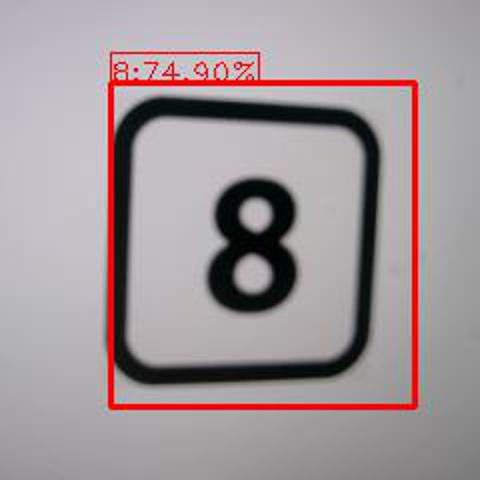


Traceback (most recent call last):
  File "<string>", line unknown, in <module>
Remote.KeyboardInterrupt


In [1]:
from maix import camera, display, image
number_recognition = Number_recognition()
while True:
    img = camera.capture()
    AI_img = img.copy().resize(224, 224)
    out = number_recognition.m.forward(AI_img.tobytes(), quantize=True, layout="hwc")
    boxes, probs = number_recognition.yolo2_decoder.run(out, nms=0.3, threshold=0.5, img_size=(240, 240))
    for i, box in enumerate(boxes):
        class_id = probs[i][0]
        prob = probs[i][1][class_id]
        disp_str = "{}:{:.2f}%".format(number_recognition.labels[class_id], prob*100)
        font_wh = image.get_string_size(disp_str)
        box = number_recognition.map_face(box)
        img.draw_rectangle(box[0], box[1], box[0] + box[2], box[1] + box[3], color = (255, 0, 0), thickness=2)
        img.draw_rectangle(box[0], box[1] - font_wh[1], box[0] + font_wh[0], box[1], color= (255, 0, 0))
        img.draw_string(box[0], box[1] - font_wh[1], disp_str, color= (255, 0, 0))
    display.show(img)
